Conneting Google Drive and Google Colab

In [49]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Alzheimer_Research_Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Libraries

In [50]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns 
import tensorflow as tf
import matplotlib.cm as cm
import plotly.express as px
import Cluster_Ensembles as CE
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.manifold import TSNE
from scipy.spatial import distance
from keras.models import load_model
from sklearn.decomposition import PCA 
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AffinityPropagation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Activation
from sklearn.metrics import silhouette_samples, silhouette_score, normalized_mutual_info_score, jaccard_score

Loading Data

In [ ]:
data = np.load('data.npy', allow_pickle=True)
targets = np.load('targets.npy', allow_pickle=True)
ids = np.load('idfs.npy', allow_pickle=True)

In [ ]:
print(len(data), 'individuals.')
print(len(data[0]), 'letters written by each individual.') 
print(len(data[0][0]), 'observations for each letter.') 
print(len(data[0][0][0]), 'measurements for each observation: v(x) and v(y).') 

54 individuals.
16 letters written by each individual.
176 observations for each letter.
2 measurements for each observation: v(x) and v(y).


In [ ]:
print(len(targets), 'target values, 1 for each individual')
print(np.unique(targets), ' Label 0: Healthy Control - Label 1: Alzheimer Patient') 
print(len(ids), 'ids, 1 distinct id for each individual') 

54 target values, 1 for each individual
[0 1]  Label 0: Healthy Control - Label 1: Alzheimer Patient
54 ids, 1 distinct id for each individual


Data Pre-Processing

In [ ]:
print(data.shape)

new_data = np.zeros((54, 16, 176, 2))

for i in range(len(data)):
  for j in range(len(data[0])):
    for k in range(len(data[0][0])):
      for l in range(len(data[0][0][0])):
        new_data[i][j][k][l] = data[i][j][k][l]

print(new_data.shape)

(54,)
(54, 16, 176, 2)


In [ ]:
# Data Augmentation

final_data = []
for i in range (54):
  for j in range (16): # seperating the l letters so that each l letter is a unique observation --> obtaining 16 samples from a single one
    final_data.append(new_data[i][j])

final_target = []
for i in range (54):
  for j in range (16):
    final_target.append(targets[i]) # each l letter has now a label --> appending the same target 16 times

final_data = np.array(final_data)
final_target = np.array(final_target)

print(final_data.shape)
print(final_data[0].shape) # this should be the input_shape of our NN

(864, 176, 2)
(176, 2)


Feature Extraction

In [ ]:
input_shape = (176, 2)

input = tf.keras.layers.Input(shape = input_shape, name='input')

x = Conv1D(6, 12, strides=(1,), input_shape=input.shape)(input)
x = Activation('relu')(x)
x = Conv1D(12, 12, strides=(1,))(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=4)(x)

x = Dropout(.5)(x)

x = Conv1D(24, 12, strides=(1,))(x)
x = Activation('relu')(x)
x = Conv1D(48, 12, strides=(1,))(x)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Dropout(.6)(x)

x = Flatten()(x)

x = Dense(144)(x)
#x = Dense(50)(x)
x = Dense(1)(x)

output = Activation('sigmoid')(x)

model = tf.keras.Model(input, output, name="CNN")

In [ ]:
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 176, 2)]          0         
                                                                 
 conv1d_12 (Conv1D)          (None, 165, 6)            150       
                                                                 
 activation_15 (Activation)  (None, 165, 6)            0         
                                                                 
 conv1d_13 (Conv1D)          (None, 154, 12)           876       
                                                                 
 activation_16 (Activation)  (None, 154, 12)           0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 38, 12)           0         
 1D)                                                             
                                                               

In [ ]:
data_train, data_val, target_train, target_val = train_test_split(final_data, 
                                                                  final_target, 
                                                                  train_size=0.6, 
                                                                  stratify=final_target)
print(data_train.shape)
print(target_train.shape)

(518, 176, 2)
(518,)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Defining the parameters
num_epochs = 60
batch_size = 64

# Training the model
history = model.fit(data_train, 
                    target_train, 
                    epochs=num_epochs, 
                    batch_size=batch_size, 
                    validation_data=(data_val, target_val))

Epoch 1/60
9/9 [==============================] - 1s 30ms/step - loss: 0.6841 - accuracy: 0.5598 - val_loss: 0.6586 - val_accuracy: 0.6329
Epoch 2/60
9/9 [==============================] - 0s 8ms/step - loss: 0.6567 - accuracy: 0.6081 - val_loss: 0.6415 - val_accuracy: 0.6416
Epoch 3/60
9/9 [==============================] - 0s 9ms/step - loss: 0.6211 - accuracy: 0.6467 - val_loss: 0.6171 - val_accuracy: 0.6618
Epoch 4/60
9/9 [==============================] - 0s 14ms/step - loss: 0.6155 - accuracy: 0.6776 - val_loss: 0.6032 - val_accuracy: 0.6590
Epoch 5/60
9/9 [==============================] - 0s 8ms/step - loss: 0.5904 - accuracy: 0.6892 - val_loss: 0.5870 - val_accuracy: 0.6676
Epoch 6/60
9/9 [==============================] - 0s 8ms/step - loss: 0.5597 - accuracy: 0.7297 - val_loss: 0.6105 - val_accuracy: 0.6908
Epoch 7/60
9/9 [==============================] - 0s 8ms/step - loss: 0.5745 - accuracy: 0.7027 - val_loss: 0.5941 - val_accuracy: 0.6647
Epoch 8/60
9/9 [================

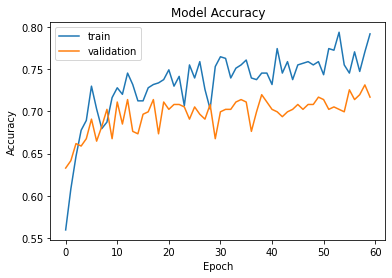

In [ ]:
# Summarizing history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#model.save('model_144F.h5')
#model.save('model_50F.h5')
#model.save('model_10F.h5')

In [51]:
model = load_model('model_144F.h5')
#model = load_model('model_50F.h5')
#model = load_model('model_10F.h5')

In [ ]:
# Building the same Neural Network but without the last layer

input = tf.keras.layers.Input(shape = input_shape)

x = input
for layer in model.layers[1:-2]:
  x = layer(x)

model2 = tf.keras.Model(input, x)

model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 2)]          0         
                                                                 
 conv1d_16 (Conv1D)          (None, 165, 6)            150       
                                                                 
 activation_20 (Activation)  (None, 165, 6)            0         
                                                                 
 conv1d_17 (Conv1D)          (None, 154, 12)           876       
                                                                 
 activation_21 (Activation)  (None, 154, 12)           0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 38, 12)           0         
 1D)                                                             
                                                             

In [ ]:
features = []
for i in range(len(final_data)):
  temp = np.array(tf.squeeze(model2.predict(final_data[i][None, :])))
  features.append(temp)

features = np.array(features)

In [ ]:
# Note: We used tf.squeeze to remove the dimension of size 1 from the shape of the tensors
print(model2.predict(final_data[0][None, :]).shape)
print(features[0].shape)

(1, 144)
(144,)


In [ ]:
df = pd.DataFrame(features)
print(df.shape)

ind_df = df.groupby(np.arange(len(df))//16).mean()
print(ind_df.shape)

ind_features = ind_df.to_numpy()

(864, 144)
(54, 144)


### Clustering

In [ ]:
nb_clusters = 4

k_means = KMeans(n_clusters=nb_clusters, n_init=10, max_iter=300)
k_means.fit(ind_features)
labels = k_means.labels_

Separability Study

In [ ]:
#labels = labels_ce # in the case of Consensus Clustering

cluster_labels = ['Cluster '+ str(i+1) for i in labels]
str_targets = ['Alzheimer' if i==1 else 'Control' for i in targets]

groups=[]
clusters=[]

for i in np.unique(labels).astype(int):
  groups.append(np.where(labels==i)[0]) 
  clusters.append(ids[groups[i]])

ids_targets = {}
for id, target in zip(ids, targets):
    ids_targets[id] = target

cluster_targets =[]
for cluster in clusters:
  cluster_target = []
  for ind in cluster: 
     cluster_target.append(ids_targets[ind])
  cluster_targets.append(cluster_target)

l0_percents = []
l1_percents = []
cluster_sizes = []

for cluster_target in cluster_targets:
  l0_percent = round(cluster_target.count(0)/len(cluster_target),3)
  l1_percent = round(cluster_target.count(1)/len(cluster_target),3)
  cluster_sizes.append(len(cluster_target))
  l0_percents.append(l0_percent)
  l1_percents.append(l1_percent)

l0_percents = ["{0:.0%}".format(i) for i in l0_percents]
l1_percents = ["{0:.0%}".format(i) for i in l1_percents]


In [ ]:
nb_clusters = len(clusters)

sep_df = pd.DataFrame([l0_percents, l1_percents, cluster_sizes],
                      index= ['Control', 'Alzheimer', 'Size'],
                      columns= 'Cluster ' + pd.RangeIndex(start=1, stop=nb_clusters+1, step=1).astype('string'))

sep_df=sep_df.T
sep_df['Size'] = sep_df['Size'].astype('int')
sep_df

,Control,Alzheimer,Size
Cluster 1,96%,4%,22
Cluster 2,19%,81%,16
Cluster 3,100%,0%,3
Cluster 4,0%,100%,13


Data Visualization

In [ ]:
#T-SNE with 2 dimensions

warnings.filterwarnings("ignore")

perplexity = 10
tsne_2d = TSNE(n_components=2, perplexity=perplexity, random_state=1)
TCs_2d = pd.DataFrame(tsne_2d.fit_transform(ind_df))
TCs_2d.columns = ["TC1_2d","TC2_2d"]

fig = px.scatter(TCs_2d, 
                 x="TC1_2d", 
                 y="TC2_2d", 
                 color=cluster_labels, 
                 symbol=str_targets, 
                 symbol_sequence= ['cross', 'circle'],
                 width=700, height=500, 
                 labels={"TC1_2d": "TC1",
                         "TC2_2d": "TC2",
                         "symbol": "Label",
                         "color": "Cluster"})

fig.update_layout({'plot_bgcolor': 'rgba(0, 100, 255, 0.05)'}, showlegend=False)
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.show()

In [ ]:
#PCA with 2 principal components

pca_2d = PCA(n_components=2)

PCs_2d = pd.DataFrame(pca_2d.fit_transform(ind_df))
PCs_2d.columns = ["PC1_2d", "PC2_2d"]

fig = px.scatter(PCs_2d, 
                 x="PC1_2d", 
                 y="PC2_2d", 
                 color=cluster_labels, 
                 symbol=str_targets, 
                 symbol_sequence= ['cross', 'circle'],
                 width=800, height=500, 
                 labels={"PC1_2d": "PC1",
                         "PC2_2d": "PC2",
                         "symbol": "Label",
                         "color": "Cluster"})
                                                                            
fig.update_layout({'plot_bgcolor': 'rgba(0, 100, 255, 0.05)'}, showlegend=False)
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.show()

In [ ]:
print("Cluster Labels: \n", labels, "\n")
print("Cluster IDs: \n",clusters, "\n")
print("Cluster Targets: \n",cluster_targets,"\n")

Cluster Labels: 
 [1 2 0 3 0 3 0 3 1 3 0 1 3 2 1 1 0 3 3 0 0 0 2 0 3 1 1 1 1 1 0 1 1 0 3 3 0
 1 3 0 0 0 0 0 1 1 0 0 0 0 0 1 3 3] 

Cluster IDs: 
 [array(['BA SE_09_10_1941', 'BE MO_21_12_1943', 'BR AN_22_09_1944',
       'CA MO_25_05_1936', 'DA MI_16_05_1949', 'FE CE_30_09_1945',
       'GA AN_28_03_1940', 'GA MI_19_10_1941', 'HI FR_25_06_1954',
       'MA FR_02_09_1934', 'ME AN_05_12_1947', 'MO AR_14_01_1938',
       'NE CH_21_03_1951', 'PA CL_01_09_1941', 'PA CO_27_08_1936',
       'PA LO_06_12_1941', 'PE JE_06_11_1940', 'RO FR_29_08_1939',
       'RO MA_19_03_1951', 'TH DE_29_11_1947', 'TU CO_14_06_1939',
       'VA JE_26_12_1940'], dtype='<U16'), array(['BA MA_28_05_1941', 'CA FR_01_10_1935', 'CE HU_13_07_1931',
       'CO ER_18_05_1935', 'DA MI_01_11_1931', 'JO AN_05_04_1945',
       'KH LA_31_01_1934', 'LA DE_04_01_1935', 'LA LO_23_06_1926',
       'LE ME_09_11_1929', 'MA GE_18_02_1941', 'MA TA_18_05_1931',
       'MO MA_21_08_1944', 'RA MA_21_07_1930', 'RO BE_18_12_1928',
      

Affinity Propagation

In [ ]:
ap_model = AffinityPropagation(damping=0.8, max_iter=200)
ap_model.fit(ind_features)

labels = ap_model.labels_
nb_clusters = len(np.unique(labels))
print(ap_model.labels_+1)

[3 1 2 3 2 6 2 6 3 3 2 3 3 4 5 5 2 6 3 4 2 5 4 2 6 5 3 3 5 3 5 5 3 5 6 6 2
 5 3 5 5 2 2 4 5 5 5 5 4 5 5 5 3 3]


Normalized Mutual Information

In [ ]:
NMI_scores = []

for n_clusters in range(2, 7): 
    k_means = KMeans(n_clusters, n_init=10, max_iter=300) 
    k_means.fit(ind_features)
    nmi = normalized_mutual_info_score(k_means.labels_, targets)
    NMI_scores.append(round(nmi,3))

In [ ]:
nmi_df = pd.DataFrame([NMI_scores],
                      index= ['NMI Score'],
                      columns= 'Clusters = ' + pd.RangeIndex(start=2, stop=7, step=1).astype('string'))

nmi_df.T

,NMI Score
Clusters = 2,0.479
Clusters = 3,0.524
Clusters = 4,0.462
Clusters = 5,0.465
Clusters = 6,0.464


Consensus Clustering

In [ ]:
# k_means model 2
k_means2 = KMeans(n_clusters=nb_clusters, n_init=10, max_iter=300) 
k_means2.fit(ind_features)
labels2 = k_means2.labels_

# k_means model 3
k_means3 = KMeans(n_clusters=nb_clusters, n_init=10, max_iter=300) 
k_means3.fit(ind_features)
labels3 = k_means3.labels_

In [ ]:
print('K_means Labels:\n', labels, '\n')
print('K_means2 Labels:\n', labels2, '\n')
print('K_means3 Labels:\n', labels3, '\n')

K_means Labels:
 [2 0 0 1 0 1 0 1 1 1 0 1 1 0 2 2 0 1 1 0 0 2 0 2 1 2 1 1 2 1 2 2 2 2 1 1 0
 2 1 2 2 0 0 0 2 2 2 2 0 2 2 2 1 1] 

K_means2 Labels:
 [2 1 1 0 1 0 1 0 0 0 1 0 0 1 2 2 1 0 0 1 1 2 1 2 0 2 0 0 2 0 2 2 2 2 0 0 1
 2 0 2 2 1 1 1 2 2 2 2 1 2 2 2 0 0] 

K_means3 Labels:
 [1 2 2 0 2 0 2 0 0 0 2 0 0 2 1 1 2 0 0 2 2 1 2 1 0 1 0 0 1 0 1 1 1 1 0 0 2
 1 0 1 1 2 2 2 1 1 1 1 2 1 1 1 0 0] 



In [ ]:
# Consensus Clustering

all_labels = np.array([labels, labels2, labels3])
labels_ce = CE.cluster_ensembles(all_labels)

labels_ce

array([2, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 2, 1, 1, 0, 0, 1, 1, 2,
       1, 2, 0, 2, 0, 0, 2, 0, 2, 2, 1, 2, 0, 0, 1, 2, 0, 2, 2, 1, 1, 1,
       2, 2, 2, 2, 1, 2, 2, 2, 0, 0])

Silhouette Analysis

In [ ]:
silhouettes = []

for n_clusters in range(3, 7): 
    k_means = KMeans(n_clusters, n_init=10, max_iter=300) 
    k_means.fit(ind_features)
    score = silhouette_score(ind_features, k_means.labels_, metric='euclidean')
    silhouettes.append(score)

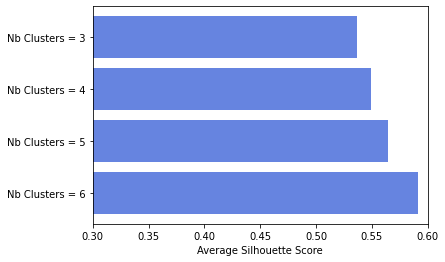

In [ ]:
y_axis = 'Nb Clusters = ' + pd.RangeIndex(start=3, stop=7, step=1).astype('string')
x_axis = silhouettes

plt.barh(y_axis, x_axis, color=(0.0, 0.2, 0.8, 0.6)) # green: 0.3, 0.7, 0.2, 0.5 #red:(0.9, 0.0, 0.0, 0.5) # blue:(0.0, 0.2, 0.8, 0.6)
plt.xlabel('Average Silhouette Score')
plt.xlim(0.3, 0.6)
plt.xticks(np.arange(0.3, 0.61, step=0.05))
plt.gca().invert_yaxis()
plt.show()

For nb clusters = 3 The average silhouette score is : 0.5258466
For nb clusters = 4 The average silhouette score is : 0.5092517
For nb clusters = 5 The average silhouette score is : 0.5093388
For nb clusters = 6 The average silhouette score is : 0.49030527


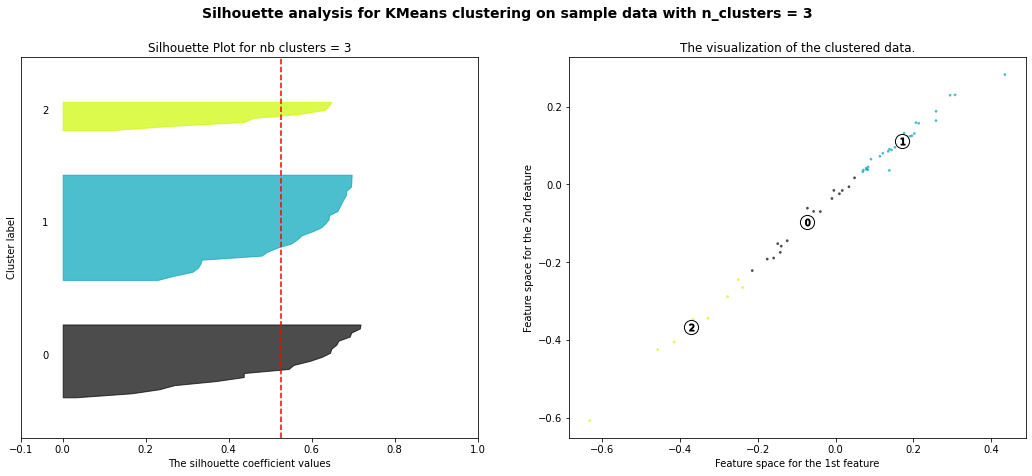

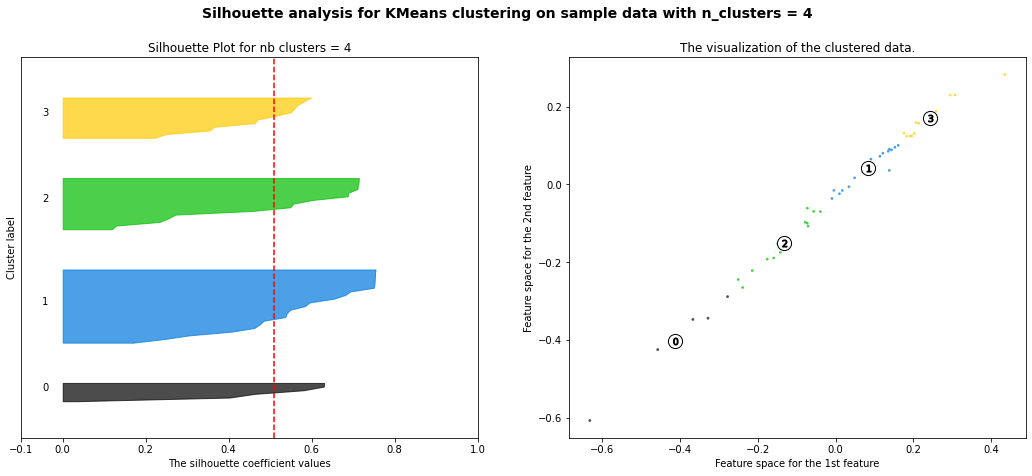

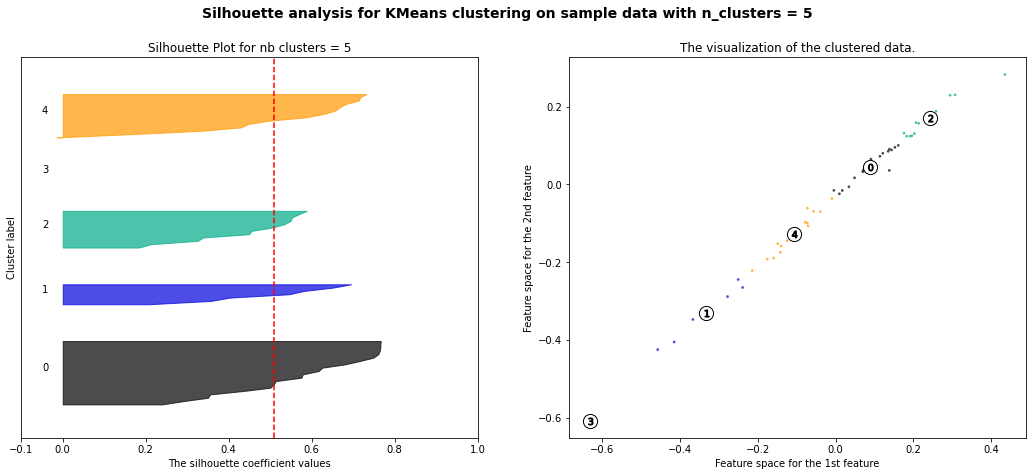

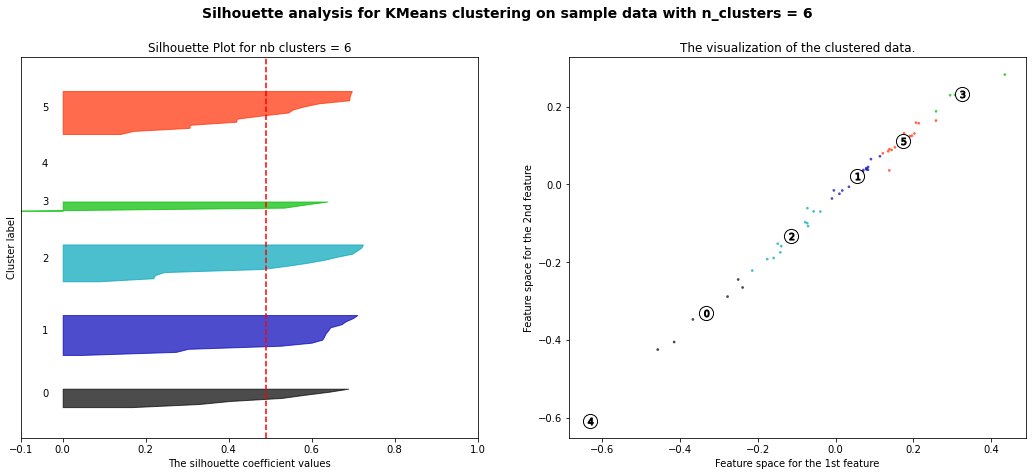

In [ ]:
# Silhouette Plot

X = ind_features
range_n_clusters = [3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # 1st Plot - Silhouette Plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10,  n_init=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For nb clusters =",
        n_clusters,
        "The average silhouette score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_title("Silhouette Plot for nb clusters = %d"% n_clusters)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot - Actual Clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_ 
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Prediction Strength

In [ ]:
def get_closest_centroid(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    min_distance = sys.float_info.max
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid

In [ ]:
def get_prediction_strength(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    n_test = len(x_test)
    
    # populate the co-membership matrix
    D = np.zeros(shape=(n_test, n_test))
    for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
        for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0
    
    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        s = 0
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        ss.append(s / (n_examples_j * (n_examples_j -1))) 

    prediction_strength = min(ss)

    return prediction_strength

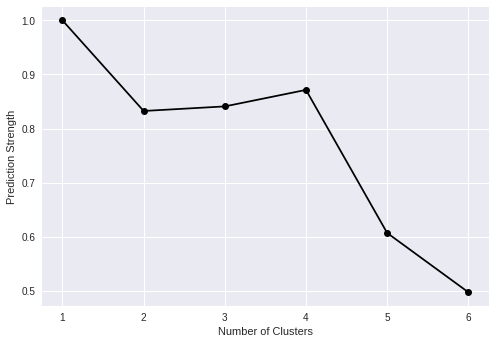

In [ ]:
# Running the Clustering 

X = features
X_train, X_test = train_test_split(X, test_size=0.3, shuffle=True)

clusters = range(1, 7)

strengths = []
for k in clusters:
    model_train = KMeans(n_clusters=k, n_init=10).fit(X_train) 
    model_test = KMeans(n_clusters=k, n_init=10).fit(X_test) 
    
    pred_str = get_prediction_strength(k, model_train.cluster_centers_, X_test, model_test.labels_)
    strengths.append(pred_str)

_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
#ax.axhline(y=0.8, c='red');
ax.set(xlabel='Number of Clusters', 
       ylabel='Prediction Strength');